In [46]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, accuracy_score
from sklearn.linear_model import LogisticRegression
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.api as sm
from sklearn.metrics import roc_curve, roc_auc_score
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session
df = pd.read_csv('/kaggle/input/weather-dataset-rattle-package/weatherAUS.csv')
print(df.columns)



/kaggle/input/weather-dataset-rattle-package/weatherAUS.csv
Index(['Date', 'Location', 'MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation',
       'Sunshine', 'WindGustDir', 'WindGustSpeed', 'WindDir9am', 'WindDir3pm',
       'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am', 'Humidity3pm',
       'Pressure9am', 'Pressure3pm', 'Cloud9am', 'Cloud3pm', 'Temp9am',
       'Temp3pm', 'RainToday', 'RainTomorrow'],
      dtype='object')


Young, Joe and Young, Adam. 2020. Rain in Australia (Data set). In Kaggle. Kaggle Inc. https://www.kaggle.com/datasets/jsphyg/weather-dataset-rattle-package/data

Dataset size is 145460 samples, with 23 columns.

Features:

Date (date) - The date the weather was recorded  
Location (string) - The location of the weather station  
MinTemp (float) - Minimum temperature that day  
MaxTemp (float) - Max temperature that day  
Rainfall (float) - Rainfall in mm. For a day to classify as a rainy day, rainfall must be >1mm.  
Evaporation (float) - Amount of water evaoporated  
Sunshine (float) - Number of hours of sunshine in the day  
WindGustDir (string) - The direction of the strongest wind gust in the 24 hours to midnight  
WindGustSpeed (string) - The speed (km/h) of the strongest wind gust in the 24 hours to midnight  
WindDir9am (string) - Direction of the wind at 9am  
WindDir3pm (string) - Direction of the wind at 3pm  
WindSpeed9am (string) - Speed of the wind at 9am  
WindSpeed3pm (string) - Speed of the wind at 3pm  
Humidity9am (float)  
Humidity3pm (float)  
Pressure9am (float)  
Pressure3pm (float)  
Cloud9am (int) - Cloud cover in oktas. Scale from 0-9, 0 is completely clear, 8 is full cloud cover, 9 is sky obscured by fog or other phenomena.  
Cloud3pm (int)  
Temp9am (float)  
Temp3pm (float)   
RainToday (boolean)  
RainTomorrow (boolean)  

Observations have been gathered from multiple weather stations in Australia.


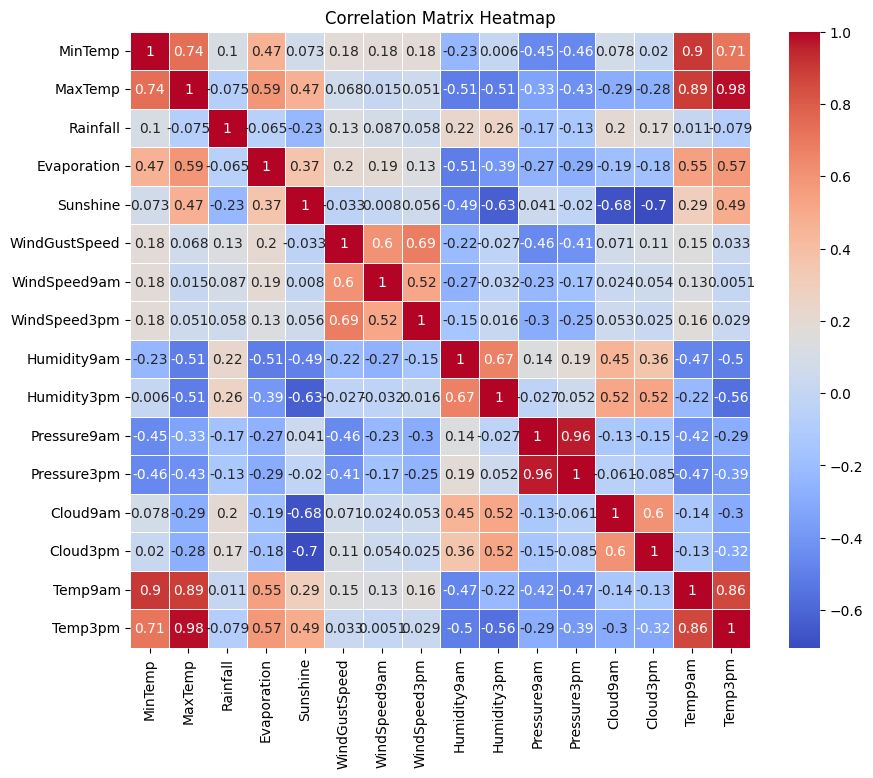

In [47]:

df = df.dropna(subset=['RainTomorrow'])
numerical_df = df.select_dtypes(include='number')
correlation_matrix = numerical_df.corr()
df = df.drop(columns=['Sunshine','Temp9am','Temp3pm'])

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Matrix Heatmap')
plt.show()

df = df.dropna()


Data Cleaning

Although the data set initially had about 145k rows, I removed all rows with NA in the RainTomorrow column - this is our dependent variable, and we need it for the training data.

There is significant correlation between minTemp, maxTemp and temp9AM and temp3PM. I dropped the 9AM and 3PM as they had more NA values than the minTemp and maxTemp columns.

The sunshine column had almost 70k NA values, and given the high correlation with the cloud9am and cloud3pm measures I dropped this column as well.

We are left with almost 62K samples for our 20-feature dataset!

Our data includes a date column. It's not perfect, but we'll morph this from a yyyy-mm-dd date to integers from 1 to 12 for month.

RainToday and RainTomorrow (target) are currently set to Yes or No, we will map that to 1 and 0.





In [48]:
df['Date'] = pd.to_datetime(df['Date'])
df['Month'] = df['Date'].dt.month
df = df.drop(columns='Date')



We do have a problem, however. Our data is very imbalanced, with 48,439 days with no rain recorded (78%), and 13,542 days with rain recorded (22%). We will experiment with some different methods to attempt to counteract the imbalance in the data.

Another challenge is that we have collected data from different weather stations across Australia. There could be inherent climate differences due to the location of the weather station. We'll do some visualizations looking at Rainfall, MinTemp, MaxTemp, and Cloud3pm.

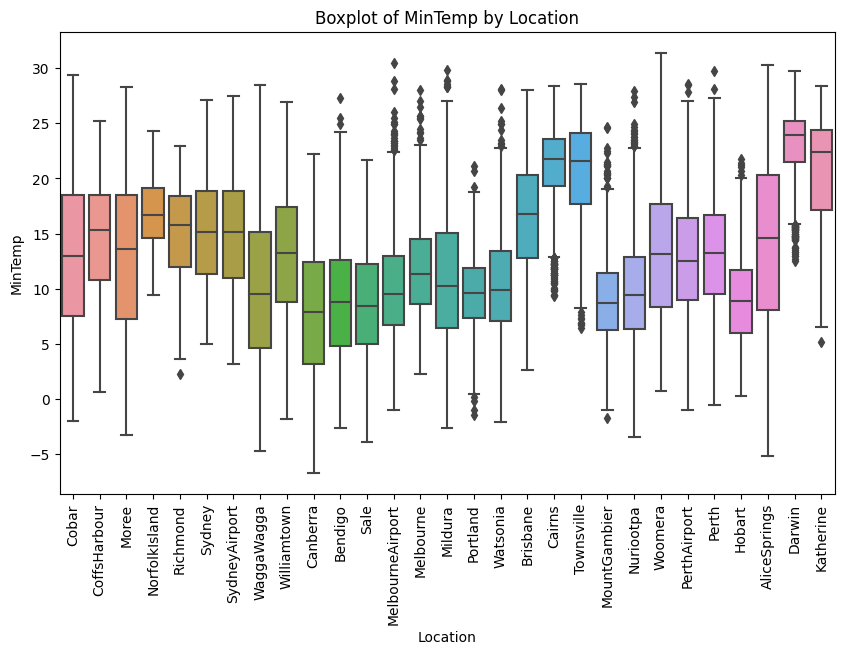

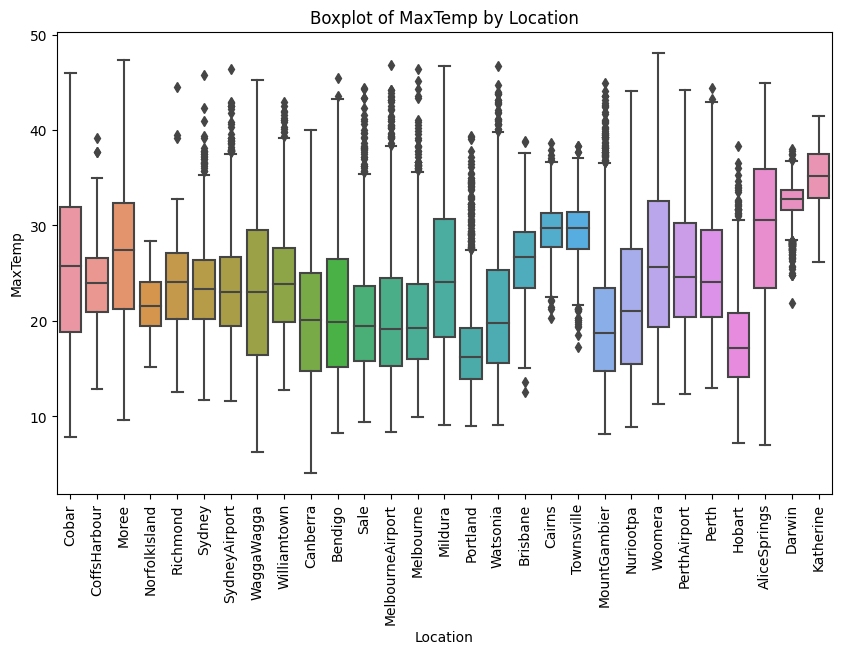

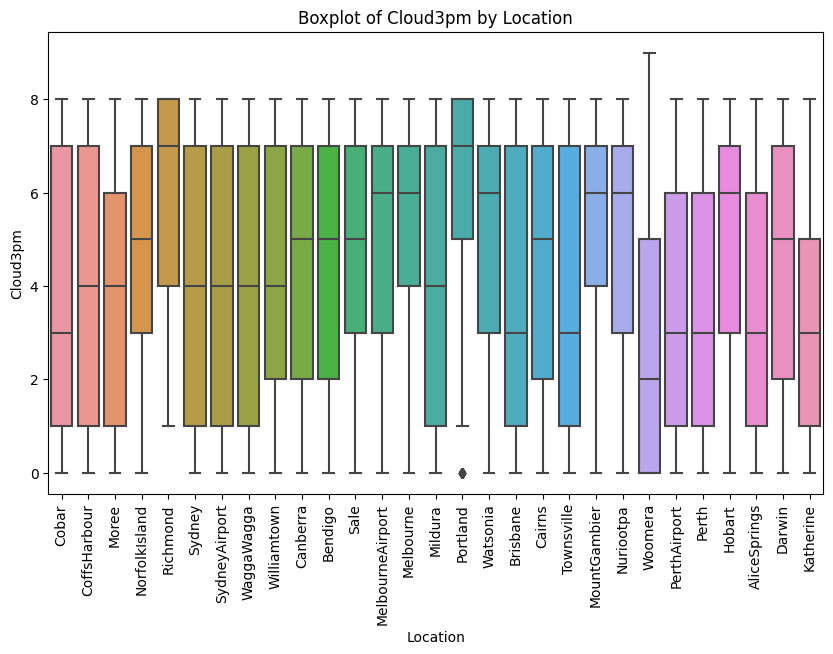

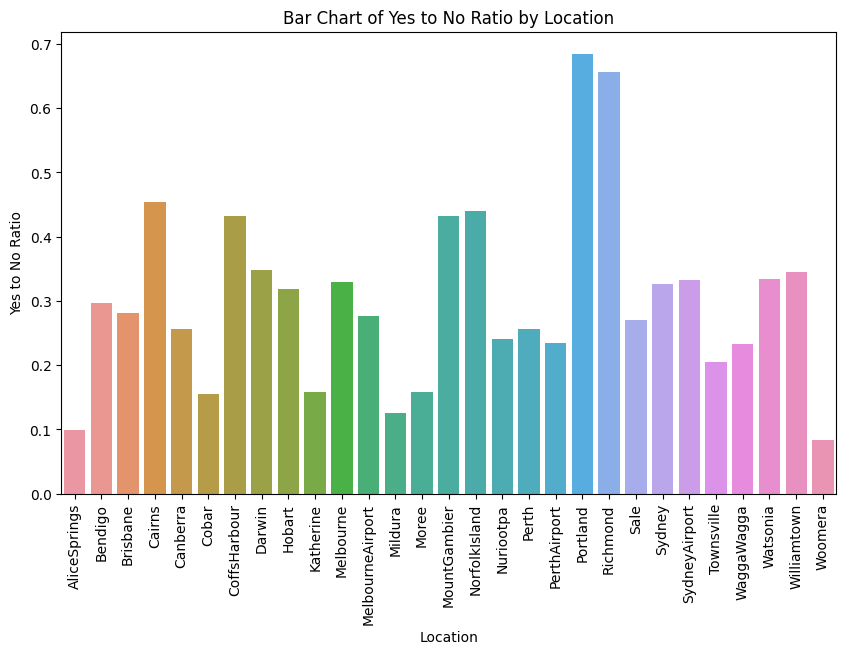

In [49]:

columns = ['MinTemp', 'MaxTemp','Cloud3pm']
for col in columns:
    plt.figure(figsize=(10, 6))
    sns.boxplot(x='Location', y=col, data=df)
    plt.title(f'Boxplot of {col} by Location')
    plt.xticks(rotation=90)
    plt.show()



counts = df.groupby('Location')['RainTomorrow'].value_counts().unstack()



counts['Yes_to_No_Ratio'] = counts['Yes'] / counts['No']

counts['Yes_to_No_Ratio'] = counts['Yes_to_No_Ratio'].replace([float('inf'), -float('inf')], 0).fillna(0)

ratios = counts[['Yes_to_No_Ratio']].reset_index()


plt.figure(figsize=(10, 6))
sns.barplot(x='Location', y='Yes_to_No_Ratio', data=ratios)
plt.title('Bar Chart of Yes to No Ratio by Location')
plt.xlabel('Location')
plt.ylabel('Yes to No Ratio')
plt.xticks(rotation=90) 
plt.show()

I don't have domain knowledge in weather, but the chart above shows the ratio of rainy days to non-rainy days recorded for each area. Areas like Portland recorded rain almost 70% of the time, with other areas under 10%! Our confusion matrix and associated metrics will be important for assessing how well our models perform.

Given that we are working with imbalanced data, we will first try decision trees and random forests. We will experiment with undersampling to get produce a more balanced data set, and try logistic regression. Lastly, we will experiment with normalizing the data, to running the same models to see if performance varies, and use the normalized data to try a model not covered in this course,. Let's begin with decision trees.

We'll first split our dataset into training and test data, and then iteratively fit and measure results using different criterion and maximum number of features to split.

In [50]:
df['RainTomorrow'] = df['RainTomorrow'].map({'Yes': 1, 'No': 0})
df['RainToday'] = df['RainToday'].map({'Yes': 1, 'No': 0})

categorical_cols = ['Location','WindGustDir', 'WindDir9am', 'WindDir3pm']
df = pd.get_dummies(df, columns=categorical_cols, drop_first=True,dtype='int')
y=df['RainTomorrow']
X = df.drop(columns='RainTomorrow')

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

crit = ['gini', 'entropy', 'log_loss']
max_features = [3,5,10,20]

print('DECISION TREE RESULTS')
for c in crit:
    for f in max_features:
        clf = DecisionTreeClassifier(random_state=42, criterion=c,max_features = f)
        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_test)
        cm = confusion_matrix(y_test, y_pred)
        precision = precision_score(y_test, y_pred)
        recall = recall_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)
        accuracy = accuracy_score(y_test, y_pred)
        print(f'For metric {c} and max features {f}, precision was {precision}, recall was {recall}, accuracy was {accuracy}, f1 was {f1}.')


DECISION TREE RESULTS
For metric gini and max features 3, precision was 0.4868868382710053, recall was 0.49555116164112706, accuracy was 0.7766066146813659, f1 was 0.4911807937285644.
For metric gini and max features 5, precision was 0.5044269552385637, recall was 0.5069204152249135, accuracy was 0.7843506318902931, f1 was 0.5056706114398423.
For metric gini and max features 10, precision was 0.5230094959824689, recall was 0.5308947108255067, accuracy was 0.7925786501747781, f1 was 0.5269226051760088.
For metric gini and max features 20, precision was 0.5218203033838973, recall was 0.5526445872466633, accuracy was 0.7924710943802097, f1 was 0.5367903012843596.
For metric entropy and max features 3, precision was 0.49558192375662713, recall was 0.4851705388037568, accuracy was 0.7805324011831137, f1 was 0.490320969151992.
For metric entropy and max features 5, precision was 0.49559902200489, recall was 0.5009886307464162, accuracy was 0.7804786232858295, f1 was 0.4982792527040314.
For m

Our accuracy is around 78%, which might not seem terrible, however precision and recall are around 50% which is poor. The precision metric tells us that basically half of the positives are false positives! Much of the accuracy may still be due to the imbalanced data, with no rain being more likely. We will see if we get better results with a random forest.

In [51]:
print('RANDOM FOREST RESULTS')
for c in crit:
    for f in max_features:
        clf = RandomForestClassifier(random_state=42, criterion=c,max_features = f,n_estimators=200)
        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_test)
        cm = confusion_matrix(y_test, y_pred)
        precision = precision_score(y_test, y_pred)
        recall = recall_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)
        accuracy = accuracy_score(y_test, y_pred)
        print(f'For metric {c} and max features {f}, precision was {precision}, recall was {recall}, accuracy was {accuracy}, f1 was {f1}.')

RANDOM FOREST RESULTS
For metric gini and max features 3, precision was 0.7826969943135662, recall was 0.4762728620860109, accuracy was 0.8572734606076903, f1 was 0.5921942224953903.
For metric gini and max features 5, precision was 0.7802827665265571, recall was 0.504695996045477, accuracy was 0.8613068029040064, f1 was 0.6129371154134774.
For metric gini and max features 10, precision was 0.7637099742362901, recall was 0.5128521997034108, accuracy was 0.8594783543963431, f1 was 0.6136330031051308.
For metric gini and max features 20, precision was 0.7618194842406877, recall was 0.5257043994068216, accuracy was 0.8610379134175854, f1 was 0.6221117285756069.
For metric entropy and max features 3, precision was 0.7827502034174125, recall was 0.47553138902619874, accuracy was 0.8571659048131218, f1 was 0.5916359163591636.
For metric entropy and max features 5, precision was 0.7743808049535603, recall was 0.4945625308947108, accuracy was 0.8586716859370799, f1 was 0.6036199095022624.
For 

Significantly better results here - I left the number of decision trees as n=200. Accuracy around 86%, and precision up to 78%. Recall is still very poor however. At around 50%, of all of the test cases where rain happened, we are really only getting about half of those. Can we do better? We will try undersampling the data to correct the imbalance, and see if it helps. We will try the previous approaches (decision tree and random forest), as well as logistic regression.

In addition to undersampling, we will use normalize our numeric columns to help our algorithms run faster and calculate distance more efficiently.

Before iteratively training the Logistic Regression model using different parameters, let's take a look at the Variance Inflation Factor of the variables. 

In [52]:
from imblearn.under_sampling import RandomUnderSampler
from sklearn.preprocessing import StandardScaler
import warnings
from sklearn.exceptions import ConvergenceWarning

scaler = StandardScaler()


rus = RandomUnderSampler(random_state=42)
X_resampled, y_resampled = rus.fit_resample(X, y)

cols_to_scale = ['MinTemp','MaxTemp','Rainfall','Evaporation','WindGustSpeed','WindSpeed9am',
                'WindSpeed3pm','Humidity9am','Humidity3pm','Pressure9am']

for col in cols_to_scale:
    mean = X_resampled[col].mean()
    std = X_resampled[col].std()
    X_resampled[col] = (X_resampled[col] - mean) / std
    
vif_data = pd.DataFrame()
vif_data["feature"] = X_resampled.columns
vif_data["VIF"] = [variance_inflation_factor(X_resampled.values, i) for i in range(X_resampled.shape[1])]
for index, row in vif_data.iterrows():
    print(f"Feature: {row['feature']}, VIF: {row['VIF']}")


Feature: MinTemp, VIF: 8.349193739332641
Feature: MaxTemp, VIF: 8.599903614027392
Feature: Rainfall, VIF: 1.518568626317592
Feature: Evaporation, VIF: 2.096632262327902
Feature: WindGustSpeed, VIF: 2.85168337820481
Feature: WindSpeed9am, VIF: 2.0259204699347744
Feature: WindSpeed3pm, VIF: 2.238436861761387
Feature: Humidity9am, VIF: 3.0171984609003273
Feature: Humidity3pm, VIF: 4.105393630577275
Feature: Pressure9am, VIF: 1.9751365600625046
Feature: Pressure3pm, VIF: 80.71709081610466
Feature: Cloud9am, VIF: 8.823018798561929
Feature: Cloud3pm, VIF: 9.832155443982339
Feature: RainToday, VIF: 2.646378080524822
Feature: Month, VIF: 5.189658543887077
Feature: Location_Bendigo, VIF: 1.5245130608362256
Feature: Location_Brisbane, VIF: 3.014367301517868
Feature: Location_Cairns, VIF: 3.261230580171579
Feature: Location_Canberra, VIF: 1.7259307131750152
Feature: Location_Cobar, VIF: 2.199347343333453
Feature: Location_CoffsHarbour, VIF: 2.3277474235823687
Feature: Location_Darwin, VIF: 3.4842

One challenge with our data is that many measures of weather are inherently related. A simple example would be that the minimum temperature for a given day is related to the maximum temperature. This means we will have multi-collinearity in our data. As a very general guideline a variance inflation factor greater than 5 indicates possible multicollinearity with other features, and we have that occuring multiple times in our data. It may be a balancing act - certain features may have natural multicollinearity, but still have exploratory power. We will leave the features as-is for now and experiment with dropping less important features after.

We are now going to try Logistic Regression, Decision Tree and Random Forests with our normalized, undersampled data. We are going to print out the performance of the model, as well as the model coefficients for Logistic Regression and feature importance for DT/RF, to see if we can prune some features after.

In [53]:
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.3, random_state=42)

solver = ['liblinear', 'newton-cg', 'newton-cholesky']

#this will be used to display coefficents
ordered_cols = X_train.columns.tolist()



print('LOGISTIC REGRESSION UNDER-SAMPLING RESULTS')

penalty = { 'liblinear':['l2'], 'newton-cg':['l2',None],'newton-cholesky':['l2']}

for s in solver:
    for p in penalty[s]:    
        
        with warnings.catch_warnings(record=True) as w:
           
            warnings.simplefilter("always")
        
        
            model = LogisticRegression(penalty=p,solver=s, max_iter=100)
            model.fit(X_train, y_train)
            
            if any(issubclass(warning.category, ConvergenceWarning) for warning in w):
                continue
            y_pred = model.predict(X_test)
            cm = confusion_matrix(y_test, y_pred)
            precision = precision_score(y_test, y_pred)
            recall = recall_score(y_test, y_pred)
            f1 = f1_score(y_test, y_pred)
            accuracy = accuracy_score(y_test, y_pred)
            coefficients = model.coef_[0]
            print(f'For solver {s} and penalty {p}, precision was {precision}, recall was {recall}, accuracy was {accuracy}, f1 was {f1}.')
#             print('The features/coefficients were:')
#             coeff_df = pd.DataFrame({'Feature': ordered_cols, 'Coefficient': coefficients}).sort_values(by='Coefficient', key=abs, ascending=False)
#             for index, row in coeff_df.iterrows():
#                 print(f"Feature: {row['Feature']}, Coef: {row['Coefficient']}")
            
            


LOGISTIC REGRESSION UNDER-SAMPLING RESULTS
For solver liblinear and penalty l2, precision was 0.7952813959203735, recall was 0.7982239763196842, accuracy was 0.7968250061530888, f1 was 0.7967499692231933.
For solver newton-cg and penalty l2, precision was 0.7990619600098741, recall was 0.7984706462752836, accuracy was 0.7992862416933301, f1 was 0.7987661937075878.
For solver newton-cg and penalty None, precision was 0.7986179664363278, recall was 0.7982239763196842, accuracy was 0.7989170563622938, f1 was 0.7984209227732544.
For solver newton-cholesky and penalty l2, precision was 0.7990619600098741, recall was 0.7984706462752836, accuracy was 0.7992862416933301, f1 was 0.7987661937075878.


Let's stick with solver newton-cholesky and penalty l2. 

Index(['WindGustSpeed', 'Humidity3pm', 'RainToday', 'Location_Brisbane',
       'WindDir9am_NE', 'WindDir9am_NNE', 'WindDir3pm_N', 'WindDir3pm_NNW',
       'WindDir3pm_NW', 'WindDir3pm_WNW'],
      dtype='object')
Using recursive feature elimination with 10 features, precision was 0.7769249814310473, recall was 0.7740503206709423, accuracy was 0.7763967511690869, f1 was 0.7754849870258248.
Feature: WindGustSpeed, VIF: 1.09984280453286
Feature: Humidity3pm, VIF: 1.1797486782179676
Feature: RainToday, VIF: 1.3005061197417727
Feature: Location_Brisbane, VIF: 1.071402804952777
Feature: WindDir9am_NE, VIF: 1.0511253496961293
Feature: WindDir9am_NNE, VIF: 1.0816566572730126
Feature: WindDir3pm_N, VIF: 1.0838278374735135
Feature: WindDir3pm_NNW, VIF: 1.0403210802640714
Feature: WindDir3pm_NW, VIF: 1.0503751858068304
Feature: WindDir3pm_WNW, VIF: 1.0493618035294807


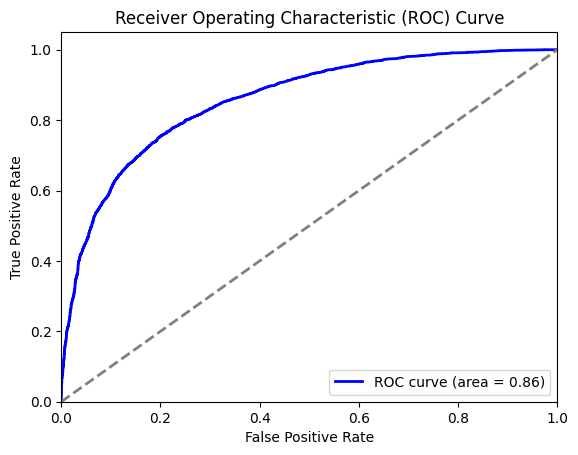

In [54]:
from sklearn.feature_selection import RFE


        
model = LogisticRegression(penalty='l2',solver='newton-cholesky', max_iter=100)
model.fit(X_train, y_train)

rfe = RFE(model, n_features_to_select=10)
rfe = rfe.fit(X_train, y_train)

selected_features = X.columns[rfe.support_]
print(selected_features)

model.fit(X_train[selected_features], y_train)
    
y_pred = model.predict(X_test[selected_features])
cm = confusion_matrix(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
accuracy = accuracy_score(y_test, y_pred)
coefficients = model.coef_[0]
y_probs = model.predict_proba(X_test[selected_features])[:, 1]

fpr, tpr, thresholds = roc_curve(y_test, y_probs)


auc = roc_auc_score(y_test, y_probs)

print(f'Using recursive feature elimination with 10 features, precision was {precision}, recall was {recall}, accuracy was {accuracy}, f1 was {f1}.')

vif_data_rfe = pd.DataFrame()
vif_data_rfe["feature"] = X_resampled[selected_features].columns
vif_data_rfe["VIF"] = [variance_inflation_factor(X_resampled[selected_features].values, i) for i in range(X_resampled[selected_features].shape[1])]
for index, row in vif_data_rfe.iterrows():
    print(f"Feature: {row['feature']}, VIF: {row['VIF']}")
    
plt.figure()
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()


In [55]:
from sklearn.preprocessing import PolynomialFeatures

poly = PolynomialFeatures(degree=2, interaction_only=True, include_bias=False)
X_trimmed = X_resampled[selected_features]

X_train_rs, X_test_rs, y_train, y_test = train_test_split(X_trimmed, y_resampled, test_size=0.3, random_state=42)


X_train_interaction = poly.fit_transform(X_train_rs)
X_test_interaction = poly.transform(X_test_rs)

feature_names = poly.get_feature_names_out(input_features=selected_features)


X_train_interaction_df = pd.DataFrame(X_train_interaction, columns=feature_names)
X_test_interaction_df = pd.DataFrame(X_test_interaction, columns=feature_names)


inter_model = LogisticRegression(penalty='l2',solver='newton-cholesky', max_iter=100)
inter_model.fit(X_train_interaction_df, y_train)

y_pred = inter_model.predict(X_test_interaction_df)
cm = confusion_matrix(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
accuracy = accuracy_score(y_test, y_pred)
coefficients = inter_model.coef_[0]

print(f'Using recursive feature elimination with 10 features as well as interaction terms, precision was {precision}, recall was {recall}, accuracy was {accuracy}, f1 was {f1}.')


Using recursive feature elimination with 10 features as well as interaction terms, precision was 0.7776409751292785, recall was 0.7789837197829305, accuracy was 0.778611863155304, f1 was 0.7783117683302527.


In [56]:


print('DECISION TREE UNDER-SAMPLING RESULTS')
for c in crit:
    for f in max_features:
        clf = DecisionTreeClassifier(random_state=42, criterion=c,max_features = f)
        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_test)
        cm = confusion_matrix(y_test, y_pred)
        precision = precision_score(y_test, y_pred)
        recall = recall_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)
        accuracy = accuracy_score(y_test, y_pred)
        print(f'For metric {c} and max features {f}, precision was {precision}, recall was {recall}, accuracy was {accuracy}, f1 was {f1}.')
        feature_importances = clf.feature_importances_
        print('Feature importances were')
        print(feature_importances)



DECISION TREE UNDER-SAMPLING RESULTS
For metric gini and max features 3, precision was 0.6927485671567406, recall was 0.6857424765663542, accuracy was 0.6914841250307654, f1 was 0.6892277178628983.
Feature importances were
[0.04749267 0.042629   0.04583549 0.04706111 0.04120613 0.03946082
 0.0359841  0.05373025 0.07532657 0.04585505 0.04937958 0.10017753
 0.11462264 0.01571347 0.02746266 0.00098262 0.00305155 0.00350827
 0.00111673 0.00266564 0.00281395 0.00288755 0.00220863 0.00089076
 0.00252279 0.00394405 0.00351227 0.00175183 0.003215   0.00403793
 0.00281342 0.0034631  0.00405521 0.00250269 0.00053523 0.00229292
 0.00264481 0.00366437 0.00227574 0.00239296 0.00209191 0.00198177
 0.00168112 0.0032232  0.00263348 0.00349881 0.00296009 0.00165721
 0.00356844 0.00284952 0.00391661 0.00291561 0.00374256 0.00297361
 0.00346731 0.00474963 0.00282445 0.00430979 0.00273565 0.00308035
 0.00404881 0.00342812 0.00372792 0.00275532 0.00260615 0.00262882
 0.00377093 0.00370865 0.00386123 0.0032

In [57]:
print('RANDOM FOREST UNDER-SAMPLING RESULTS')
for c in crit:
    for f in max_features:
        clf = RandomForestClassifier(random_state=42, criterion=c,max_features = f,n_estimators=200)
        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_test)
        cm = confusion_matrix(y_test, y_pred)
        precision = precision_score(y_test, y_pred)
        recall = recall_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)
        accuracy = accuracy_score(y_test, y_pred)
        print(f'For metric {c} and max features {f}, precision was {precision}, recall was {recall}, accuracy was {accuracy}, f1 was {f1}.')
        feature_importances = clf.feature_importances_
        print('Feature importances were')
        print(feature_importances)

RANDOM FOREST UNDER-SAMPLING RESULTS
For metric gini and max features 3, precision was 0.7936887401386564, recall was 0.8189442525900346, accuracy was 0.8034703421117401, f1 was 0.8061187325482579.
Feature importances were
[0.04479534 0.04658846 0.0481367  0.04076111 0.04931225 0.0316746
 0.03333459 0.05717611 0.11564389 0.05888705 0.05521906 0.04951095
 0.08297266 0.02598949 0.02840482 0.00127239 0.00306008 0.00274623
 0.00165661 0.00256931 0.00308372 0.00257748 0.00253761 0.00094027
 0.00250113 0.00306981 0.00319276 0.00225234 0.00308062 0.00371866
 0.00238875 0.00318645 0.00304408 0.00320303 0.00064805 0.0025621
 0.0026     0.00353949 0.00235186 0.00277272 0.0030998  0.00244909
 0.00270296 0.00322198 0.00296012 0.0039865  0.00324542 0.00311502
 0.0030532  0.00325111 0.00374562 0.00329325 0.00340651 0.0035904
 0.00354521 0.00403016 0.00365193 0.00361086 0.00332608 0.0031378
 0.00551047 0.00365165 0.00429599 0.00362664 0.00335428 0.00352638
 0.00344035 0.00335517 0.00315126 0.00351028

In [58]:
from sklearn.ensemble import AdaBoostClassifier
base = RandomForestClassifier(random_state=42, criterion='log_loss',max_features = 10,n_estimators=200)
ada = AdaBoostClassifier(estimator=base,n_estimators=200, random_state=42)
ada.fit(X_train,y_train)
y_pred = ada.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
accuracy = accuracy_score(y_test, y_pred)
print(f'For metric {c} and max features {f}, precision was {precision}, recall was {recall}, accuracy was {accuracy}, f1 was {f1}.')


For metric log_loss and max features 20, precision was 0.7959673547767643, recall was 0.8179575727676369, accuracy was 0.8045778981048486, f1 was 0.8068126520681266.


Let's look at an ROC curve for what appears to be one of the best models so far - random forest with log_loss metric and 10 max features.



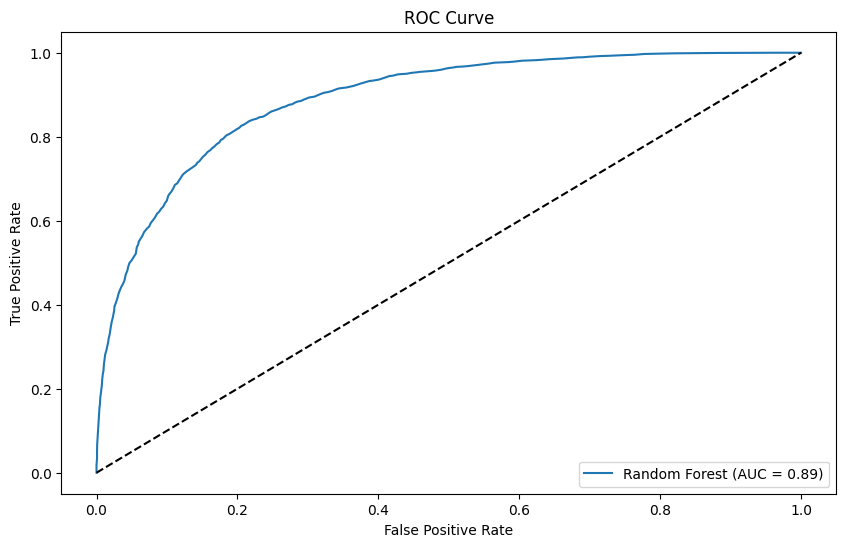

In [59]:


clf = RandomForestClassifier(random_state=42, criterion=c,max_features = f,n_estimators=200)
clf.fit(X_train, y_train)
rf_clf_probs = clf.predict_proba(X_test)[:,1]
rf_clf_fpr, rf_clf_tpr, _ = roc_curve(y_test, rf_clf_probs)
rf_clf_auc = roc_auc_score(y_test, rf_clf_probs)

plt.figure(figsize=(10, 6))
plt.plot(rf_clf_fpr, rf_clf_tpr, label=f'Random Forest (AUC = {rf_clf_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')  
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()


# Conclusions

This was a challenging dataset and a good learning experience. There are some deceptively well-performing notebooks on this dataset - specifically, notebooks with a high accuracy, but poor recall scores. When predicting something that is somewhat of an anomaly, rain in Australia, being aware of false negatives is important for building effective models.

We have experimented with Logistic Regression, Decision Trees, and Random Forests, as well as light feature engineering (normalization/scaling, one-hot encoding to convert categorical variables to binary variables, adjusting date features into month feature, as well as some interaction terms) and examinating of variance inflation factors and multi-collinearity. We used undersampling to counter a dataset that was very unbalanced.

Our best result was a random forest model that had performance of 0.8 across relevant metrics (precision, recall, accuracy, f1) as well as an AUC of 0.89. Given the scope of the course, and limitations of the dataset, this is a very good result. 

I would have liked to see a bit higher accuracy, however, the fact is this dataset is incredibly broad covering many different regions of Australia. Balancing broad data (different climates in Australia) while keeping false negatives/positives under control is very challenging. It is very likely that the variability of climate across the many locations underminded performance of our models.

Some ideas to improve performance are:

* Building individual models to predict weather in different locations (or at least clusters of locations that are known to have similar climate, domain knowledge required)
* Using domain knowledge for feature selection - we used all features at the expense of cutting the size of our dataset significantly
* Using domain knowledge to impute more values that are originally NA, to give us a larger training dataset

